## Extract the subjects view

In [1]:
import os
import scipy.io as sio
import numpy as np

In [2]:
def handle_subj_ops(subj):
    subj_file = os.path.join(src_fold, 'subject' + format(subj)+ '.mat')
    data = sio.loadmat(subj_file)['A']
    # eliminate unwanted regions
    #data = data[:, mask]

    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    #os.mkdir(subj_dest_fold)
    return data


In [3]:
def extract_subj_store(subj, data):

    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    #Proceeded by transpose  to obtain 4 matrices for each subject, already checked that it is symmetric
    data=data.transpose(2,0,1)
    #the first matrix (network) in the dataset (over 4)
    #upper_tri=np.triu(data[0])
    matrix=data[0]
    #Vectorize 
    ui=np.triu_indices(35)
    vector=matrix[ui]
    

    #f = os.path.join(subj_dest_fold, 'subjectA'+ format(subj)  + '.mat' )
    ## needed data for classification, labels and features(brain grahps' weights in our case)
    #d = {}
    #d ['vector']=vector
    #sio.savemat(f,d)
    return vector

In [4]:
def create_dataset(subjects,src_fold,dst_fold):
    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    d={}
    Features_vectors=[0 for i in range(630)]
    #v=np.array([[0 for i in range(630)]])
    for subj in subjects:
        subj_data=handle_subj_ops(subj)
        vector=extract_subj_store(subj,subj_data)
        Features_vectors=np.vstack((Features_vectors,vector))
        
        #v=np.append(v,np.array(vector))
        #d['subject'+format(subj)]=vector
    #d['A']=v
    Features_vectors=np.delete(Features_vectors,0,0)
    d['Features_vectors']=Features_vectors
    f = os.path.join(dst_fold, 'Feature_vectors' + '.mat' )
    sio.savemat(f,d)    
    

### --------------------Main------------------------

In [5]:
src_fold  = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/LH77subjects/'
label_file = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/labels77.mat'
dst_fold = '/home/raoua/Desktop/BASIRA/working repo/intermediate/'

In [6]:
subjects=range(1,78)
#for subj in subjects:
#    # read and create necessary folders
#    subj_data = handle_subj_ops(subj)
#    extract_subj_store(subj, subj_data)
create_dataset(subjects,src_fold,dst_fold)

### Start over here 

In [1]:
import scipy.io as sio
import numpy as np

In [2]:
Data=sio.loadmat('./intermediate/Feature_vectors.mat')

In [3]:
X=Data['Features_vectors']

In [4]:
X = X.astype(float)

## Data cleaning 
### Drop the null features 

In [5]:
#I transposed it the first time because the next operation of dropping the null values does not work for axis =0 
X=np.transpose(X)

In [6]:
X = X[~np.all(X == 0, axis=1)]

In [7]:
# Itranspose it back to not change the next operations 
X=np.transpose(X)

In [8]:
X.shape

(77, 589)

In [9]:
labels=sio.loadmat('./labels77.mat')

In [10]:
y=labels['labels']

In [11]:
X.dtype

dtype('float64')

### Feature selection

In [12]:
y=y[:, 0]

In [13]:
 n_samples, n_features = X.shape    # number of samples and number of features

In [14]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score
from skfeature.function.similarity_based import reliefF

### 5-fold

In [15]:
# split data into 5 folds
kf5=KFold(n_splits=5,shuffle=True)

#ss = cross_validate(n_samples, n_folds=5, shuffle=True)

In [16]:
kf5.get_n_splits(X)

5

In [17]:
# Number of selected features (top k ranked features)

#top K selected features varying from 10 to 100 (with a step size of 10 features)
num_fea = [i for i in range(10,110,10)]
clf = svm.LinearSVC()    # linear SVM
correct=0
accuracy=[]

### Feature selection methods

In [18]:
#MutInfFS

from skfeature.function.information_theoretical_based import MIFS
#laplacian
from skfeature.function.similarity_based import lap_score
from skfeature.utility import construct_W
# norm
from skfeature.function.sparse_learning_based import ll_l21
from skfeature.utility.sparse_learning import *
#UDFS
from skfeature.function.sparse_learning_based import UDFS
from skfeature.utility.sparse_learning import feature_ranking
from skfeature.function.similarity_based import fisher_score

from skfeature.function.statistical_based import chi_square

from skfeature.function.statistical_based import gini_index
from skfeature.function.information_theoretical_based import FCBF
from skfeature.function.similarity_based import trace_ratio
from skfeature.function.similarity_based import SPEC
from skfeature.function.information_theoretical_based import CIFE
from skfeature.function.streaming import alpha_investing
from skfeature.function.information_theoretical_based import CMIM
from skfeature.function.sparse_learning_based import ls_l21

from skfeature.function.sparse_learning_based import MCFS
from skfeature.utility import construct_W


In [19]:
def relief_FS(X_train,y_train):
    score=reliefF.reliefF(X_train,y_train)
    idx=reliefF.feature_ranking(score)
    return(idx)

In [20]:
def MIFS_FS(k,X_train,y_train):
    idx = MIFS.mifs(X_train, y_train, n_selected_features=k)
    #print(idx)
    return(idx)

In [21]:
def lap_score_FS():
    # construct affinity matrix
    kwargs_W = {"metric": "euclidean", "neighbor_mode": "knn", "weight_mode": "heat_kernel", "k": 5, 't': 1}
    W = construct_W.construct_W(X, **kwargs_W)
    # obtain the scores of features
    score = lap_score.lap_score(X, W=W)
    idx=lap_score.feature_ranking(score)
    return(idx)

In [22]:
def ll_l21_FS(X_train,y,train_index):
    Y = construct_label_matrix_pan(y)
    Y_train=Y[train_index]
    Weight, obj, value_gamma = ll_l21.proximal_gradient_descent(X_train, Y[train_index], 0.1, verbose=False)
    #print("weight ",Weight)
    idx = feature_ranking(Weight)
    
    return(idx)
    
    

In [23]:
def UDFS_FS():
    Weight = UDFS.udfs(X)
    idx=feature_ranking(Weight)
    return(idx)
    

In [24]:
def fisher_score_FS(X_train,y_train):
    score = fisher_score.fisher_score(X_train, y_train)
    idx = fisher_score.feature_ranking(score)
    return(idx)

In [25]:
def chi_square_FS(X,y):
    score = chi_square.chi_square(X, y)
    idx = chi_square.feature_ranking(score)
    return(idx)

In [26]:
def gini_index_FS(X_train,y_train):
    score = gini_index.gini_index(X_train, y_train)
    # rank features in descending order according to score
    idx = gini_index.feature_ranking(score)
    return(idx)

In [27]:
def FCBF_FS(X_train,y_train,k):
    #idx = FCBF.fcbf(X_train, y_train, n_selected_features=k)
    #return(idx)
    return(fcbf(X_train, y_train, n_selected_features=k))

In [28]:
def trace_ratio_FS(X,train_index,y_train):
    _,k=X.shape
    feature_idx, feature_score, subset_score=trace_ratio.trace_ratio(X[train_index], y_train, k, style='fisher')
    return(feature_idx)

In [29]:
X.shape

(77, 589)

In [30]:
def spec_FS(X_train):
    
    kwargs = {'style': 0}

    # obtain the scores of features
    score = SPEC.spec(X_train, **kwargs)

    # sort the feature scores in an descending order according to the feature scores
    idx = SPEC.feature_ranking(score, **kwargs)
    return(idx)
    

In [31]:
def CIFE_FS(X_train,y_train):
    F, J_CMI, MIfy=CIFE.cife(X_train, y_train, n_selected_features=num_fea)
    return(F)

In [32]:
def alpha_investing_FS(X_train,y_train):
    idx = alpha_investing.alpha_investing(X_train, y_train, 0.05, 0.05)
    return(idx)


In [33]:
def CMIM_FS(X_train,y_train,num_fea):
    idx,_,_ = CMIM.cmim(X_train, y_train, n_selected_features=num_fea)
    #F, J_CMIM,MIfy= CMIM.cmim(X_train, y_train, n_selected_features=k)
    return(idx)
        

In [34]:
def ls_l21_FS(X_train,y,train_index):
    Y = construct_label_matrix_pan(y)
    Y_train=Y[train_index]
    W, obj, value_gamma=ls_l21.proximal_gradient_descent(X_train, Y_train, 0.1, verbose=False)
    idx = feature_ranking(W)

    return(idx)

In [35]:
def MCFS_FS(X_train,k):
    # construct affinity matrix
    kwargs = {"metric": "euclidean", "neighborMode": "knn", "weightMode": "heatKernel", "k": 5, 't': 1}
    W = construct_W.construct_W(X_train, **kwargs)
    num_fea_ = k    # specify the number of selected features
    num_cluster = 20    # specify the number of clusters, it is usually set as the number of classes in the ground truth

    # obtain the feature weight matrix
    Weight = MCFS.mcfs(X_train, n_selected_features=num_fea_, W=W, n_clusters=20)

    # sort the feature scores in an ascending order according to the feature scores
    idx = MCFS.feature_ranking(Weight)
    return(idx)
    

_____________________________________________________________________________________________________________________________

In [36]:
from boruta_py.boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
def boruta_FS(X_train,y_train):
    rf = RandomForestClassifier(n_jobs=-1, class_weight=None, max_depth=7, random_state=0)
   # Define Boruta feature selection method 
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)
    feat_selector.fit(X_train, y_train)
    idx=feat_selector.ranking_
    return(idx)

------------------------------------------------------------------------------------------------------------------------------------

## Add more FS to the pool and implement new ones 

In [37]:
pool_FS=[reliefF,lap_score,ll_l21,ls_l21,UDFS,fisher_score,chi_square,gini_index,SPEC,BorutaPy]#,MCFS]#trace_ratio,

In [38]:
pool_FS[8]

<module 'skfeature.function.similarity_based.SPEC' from '/usr/local/lib/python3.5/dist-packages/skfeature/function/similarity_based/SPEC.py'>

____________________________________________________________________________________

### Training

In [39]:
def training(cv,k,FS_method):
    accuracy=[]
    featureranking=[]
    correct=0
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if FS_method==reliefF:
            idx=relief_FS(X_train,y_train)
        elif FS_method==MIFS: ##ERROR
            idx=MIFS_FS(k,X_train,y_train)
        elif FS_method==lap_score:
            idx=lap_score_FS()
        elif FS_method==ll_l21:
            idx=ll_l21_FS(X_train,y,train_index)
        elif FS_method==UDFS:
            idx=UDFS_FS()
        elif FS_method==fisher_score:
            idx=fisher_score_FS(X_train,y_train)
        elif FS_method==chi_square:
            idx=chi_square_FS(X_train,y_train)
        elif FS_method==gini_index:
            idx=gini_index_FS(X_train,y_train)
        elif FS_method==FCBF:
            idx=FCBF_FS(X_train,y_train,k)
        elif FS_method==BorutaPy:
            idx=boruta_FS(X_train,y_train) 
        elif FS_method==trace_ratio:
            idx=trace_ratio_FS(X,train_index,y_train)
        elif FS_method==SPEC:
            idx=spec_FS(X_train)
        elif FS_method==CIFE:#Takes too long 
            idx=CIFE_FS(X_train,y_train)
        elif FS_method==alpha_investing:#Error
            idx=alpha_investing_FS(X_train,y_train)
        elif FS_method==CMIM:# Same ranking of the original features 
            n,m=X_train.shape
            idx=CMIM_FS(X_train,y_train,m)
        elif FS_method==ls_l21:
            idx=ls_l21_FS(X_train,y,train_index)
        elif FS_method==MCFS:
            idx=MCFS_FS(X_train,k)
        
        selected_features = X[:, idx[0:k]]
        featureranking.extend([idx])

        # train a classification model with the selected features on the training dataset
        clf.fit(selected_features[train_index], y[train_index])  # predict the class labels of test data
        y_predict = clf.predict(selected_features[test_index])
        # obtain the classification accuracy on the test data
        acc = accuracy_score(y[test_index], y_predict)
        correct = correct + acc

        # output the average classification accuracy over all folds
    accuracy=float(correct)/cv.get_n_splits(X)
    return(np.array(featureranking),accuracy)

In [40]:
X.shape

(77, 589)

#### Testing the  training function

In [136]:
matrice,acc_=training(kf5,10,trace_ratio)

In [138]:
matrice

array([[174, 171, 180, ...,  46,  37,  47],
       [183, 171,   3, ...,  47, 157,  46],
       [183, 180,  97, ...,  47, 552, 157],
       [ 34, 183,   3, ..., 552, 162, 157],
       [183, 174,  34, ..., 157,  44,  62]])

In [44]:
matrice.shape

(5, 589)

In [41]:
matrice

array([[243, 426, 542, ..., 189, 384, 151],
       [268, 434, 130, ..., 575, 404, 584],
       [ 95, 564, 255, ..., 514, 212, 500],
       [173, 378, 191, ..., 535, 527, 464],
       [ 23, 358,  38, ..., 248, 477, 564]])

In [89]:
matrice

array([[319, 538,  87, ..., 585, 345, 443],
       [ 34, 492, 413, ..., 520, 513, 584],
       [ 76, 579, 125, ..., 532, 420, 511],
       [309, 558,  52, ..., 509, 443, 438],
       [ 85, 521, 128, ..., 504, 232, 506]])

In [39]:
matrice

array([[132, 353, 323, ..., 180,   3, 158],
       [132, 188, 126, ..., 159, 161, 177],
       [130, 352, 231, ..., 172, 177, 161],
       [132, 523, 131, ..., 173, 161, 177],
       [124, 585, 587, ..., 180, 173, 177]])

In [104]:
matrice0,acc_0=training(kf5,10,lap_score)

In [105]:
matrice1,acc_1=training(kf5,10,ll_l21)


### Average similarity matrix 

In [41]:
def intersection(a,b):
    ''' A function that return the percentage of common elements to both a and b'''
    sum_=0
    for x in range(a.shape[0]):
        for y in range(a.shape[1]):
            sum_+=np.sum((a[x,y]==b[x,y]))
    percentage=(sum_*100)/a.size
    return(percentage)

In [42]:
def intersect(a,b):
    ''' A function that returns unique elements common to both a and b in a pythonic way '''
    nrows, ncols = a.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],'formats':ncols * [a.dtype]}
    c = np.intersect1d(a.view(dtype), b.view(dtype))
    # This last bit is optional if you're okay with "C" being a structured array...
    c = c.view(a.dtype).reshape(-1, ncols)
    return(c)  

    

#### Overlapping function

In [43]:
def FS_to_FS_similarity(FS_k):
    n=len(FS_k)
    m=np.ones((n,n))
    for i in range(n):
        for j in range(i+1,n):
            m[i,j]=intersection(FS_k[i],FS_k[j])
            m[j,i]=m[i,j]
    for i in range(n):
        m[i,i]=intersection(FS_k[i],FS_k[i])/100
    return(m)

In [44]:

def avg_similarity(pool_FS,num_fea,cv):
    '''Input:
    
       pool_FS: pool of Feature selection methods
       num_fea: a list of different fs numbers in this case the threshold varies from 10 to 100 with step 10
       cv: Cross validation method (5-fold, 10_fold, LOO)
       
       Output: 
       
       average_similarity: average similarity matrix'''
    S_k={}
    similarities=[]
    for k in num_fea:
        FS_k=[]
    
        for FS in pool_FS:
            _feature_ranking,_acc=training(cv,k,FS)
            #FS_k_ranking.append(_feature_ranking)
            FS_k.append(_feature_ranking)
        S_k[k]=FS_to_FS_similarity(FS_k)
    for k in num_fea:
        similarities.append(S_k[k])
    average_similarity=sum(similarities)/len(num_fea)
    return(average_similarity,S_k)

### Accuracy similarity matrix

In [45]:
from statistics import mean
import math

In [46]:
def cost(ai,aj):
    sigma=10
    return(math.exp(-abs(ai-aj)/sigma))

In [47]:
def matrix_acc(list_):
    n=len(list_)
    m=np.ones((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            m[i,j]=cost(list_[i],list_[j])
            m[j,i]=m[i,j]
    for i in range(n):
        m[i,i]=cost(list_[i],list_[i])
    
    return(m)

In [48]:
def accuracy_similarity_matrix(pool_FS,num_fea,cv):
    '''Input:
    
       pool_FS: pool of Feature selection methods
       num_fea: a list of different fs numbers in this case the threshold varies from 10 to 100 with step 10
       cv: Cross validation method (5-fold, 10_fold, LOO)
       
       Output:
       FS-to-FS Accuracy similarity matrix
       
    '''
    #avg_fs_acc_over_k={}
    avg_fs_acc_over_k=[]
    #FS_columns=['reliefF','lap_score','ll_l21','UDFS','fisher_score','chi_square','gini_index']
    for FS in pool_FS:
        acc_k=[]
        for k in num_fea:
            _feature_ranking,_acc=training(cv,k,FS)
            #avg_fs_acc_over_k[k]=
            acc_k.append(_acc)
        #avg_fs_acc_over_k[str(FS.__name__.split('.')[3])]=mean(acc_k)
        avg_fs_acc_over_k.append(mean(acc_k))
    result=matrix_acc(avg_fs_acc_over_k)
    return(result)

In [68]:
FS_k=[]
S_k={}
similarities=[]
for k in num_fea:
    FS_k=[]

    for FS in pool_FS:
        _feature_ranking,_acc=training(kf5,k,FS)
        FS_k.append(_feature_ranking)
    S_k[k]=FS_to_FS_similarity(FS_k)

In [73]:
similarities=[]
for k in num_fea:
    similarities.append(S_k[k])
average_similarity=sum(similarities)/len(num_fea)

In [82]:
average_similarity

array([[1.        , 0.42105263, 0.18675722, 0.18336163, 0.17657046,
        0.46179966, 0.50594228, 0.29202037, 0.14940577, 0.16977929],
       [0.42105263, 1.        , 0.        , 0.15619694, 0.33955857,
        0.475382  , 0.55348048, 0.31578947, 0.0950764 , 0.15619694],
       [0.18675722, 0.        , 1.        , 0.39049236, 0.50933786,
        0.19354839, 0.2139219 , 0.2139219 , 0.13582343, 0.17657046],
       [0.18336163, 0.15619694, 0.39049236, 1.        , 0.17317487,
        0.13582343, 0.13242784, 0.1663837 , 0.15959253, 0.16977929],
       [0.17657046, 0.33955857, 0.50933786, 0.17317487, 1.        ,
        0.237691  , 0.16977929, 0.21052632, 0.08828523, 0.1901528 ],
       [0.46179966, 0.475382  , 0.19354839, 0.13582343, 0.237691  ,
        1.        , 0.40747029, 0.33955857, 0.13242784, 0.1663837 ],
       [0.50594228, 0.55348048, 0.2139219 , 0.13242784, 0.16977929,
        0.40747029, 1.        , 0.33616299, 0.1426146 , 0.1901528 ],
       [0.29202037, 0.31578947, 0.2139219

================ Run those functions ============================

In [78]:
avg_sim_kf5,sk_kf5=average_similarity,S_k

In [81]:
acc_sim_kf5=accuracy_similarity_matrix(pool_FS,num_fea,kf5)

In [84]:
acc_sim_kf5

array([[1.        , 0.9987591 , 0.99570923, 0.99473889, 0.99707927,
        0.99894223, 0.99972504, 0.99969171, 0.98590034, 0.99731195],
       [0.9987591 , 1.        , 0.99694634, 0.99350452, 0.99831808,
        0.99981668, 0.99848448, 0.9984512 , 0.98467694, 0.99607439],
       [0.99570923, 0.99694634, 1.        , 0.99047069, 0.99862594,
        0.99676358, 0.99543545, 0.99540227, 0.98167007, 0.99303272],
       [0.99473889, 0.99350452, 0.99047069, 1.        , 0.99183353,
        0.99368668, 0.99501248, 0.99504565, 0.99111471, 0.99742   ],
       [0.99707927, 0.99831808, 0.99862594, 0.99183353, 1.        ,
        0.99813507, 0.99680511, 0.99677189, 0.9830208 , 0.99439908],
       [0.99894223, 0.99981668, 0.99676358, 0.99368668, 0.99813507,
        1.        , 0.99866756, 0.99863427, 0.98485749, 0.99625702],
       [0.99972504, 0.99848448, 0.99543545, 0.99501248, 0.99680511,
        0.99866756, 1.        , 0.99996667, 0.9861715 , 0.99758625],
       [0.99969171, 0.9984512 , 0.9954022

In [85]:
# Final FS similarity matrix 
final_sim_kf5=np.multiply(avg_sim_kf5,acc_sim_kf5)

In [86]:
final_sim_kf5.shape

(10, 10)

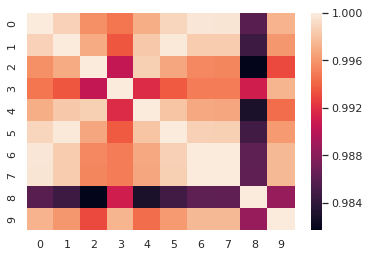

In [93]:
import seaborn as sns; sns.set()
sns.heatmap(acc_sim_kf5)

### 5-fold CV overlapping matrices

Text(0.5, 1.0, 'num_fea=100')

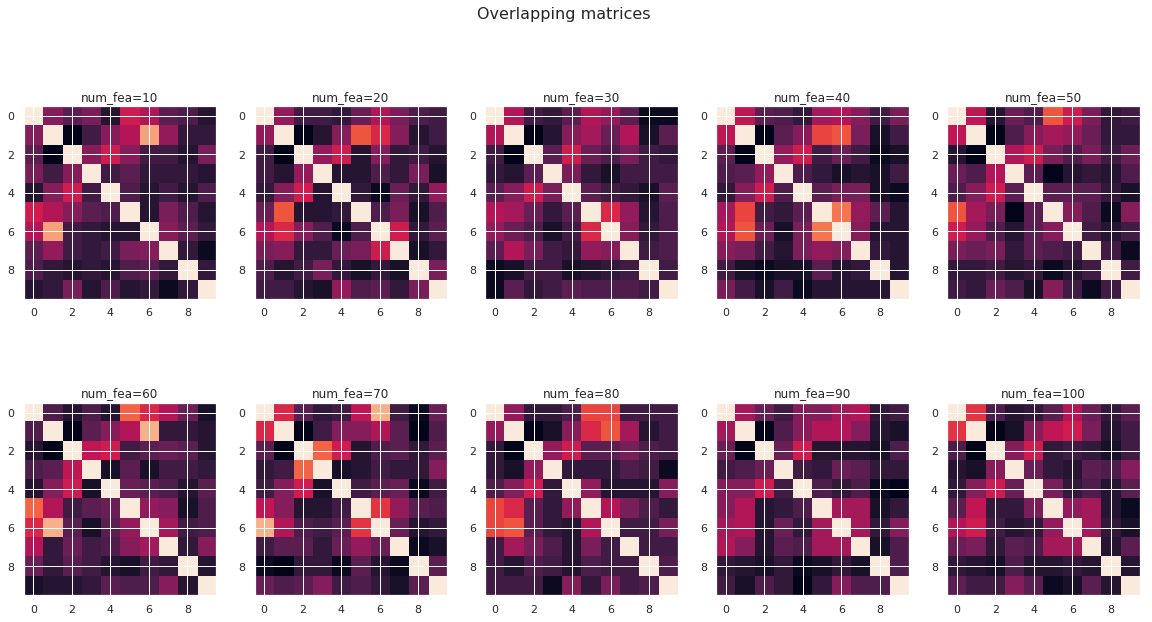

In [116]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.suptitle('Overlapping matrices', fontsize=16)

plt.subplot(2, 5, 1)
plt.imshow(sk_kf5[10])
plt.title('num_fea=10')
plt.subplot(2, 5, 2)
plt.imshow(sk_kf5[20])
plt.title('num_fea=20')
plt.subplot(2, 5, 3)
plt.imshow(sk_kf5[30])
plt.title('num_fea=30')
plt.subplot(2, 5, 4)
plt.imshow(sk_kf5[40])
plt.title('num_fea=40')
plt.subplot(2, 5, 5)
plt.imshow(sk_kf5[50])
plt.title('num_fea=50')
plt.subplot(2, 5, 6)
plt.imshow(sk_kf5[60])
plt.title('num_fea=60')
plt.subplot(2, 5, 7)
plt.imshow(sk_kf5[70])
plt.title('num_fea=70')
plt.subplot(2, 5, 8)
plt.imshow(sk_kf5[80])
plt.title('num_fea=80')
plt.subplot(2, 5, 9)
plt.imshow(sk_kf5[90])
plt.title('num_fea=90')
plt.subplot(2, 5, 10)
plt.imshow(sk_kf5[100])
plt.title('num_fea=100')



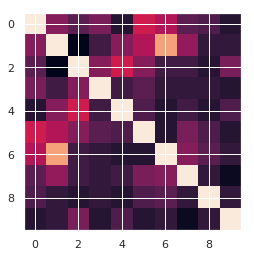

In [98]:
plt.imshow(sk_kf5[10])

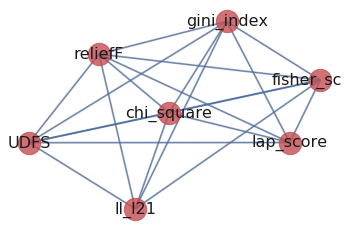

In [67]:
import matplotlib.pyplot as plt

import networkx as nx

G=nx.from_numpy_matrix(final_sim_kf5)
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[0,1,2,3,4,5,6],
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
#nx.draw_networkx_nodes(G,pos,
#                       nodelist=[4,5,6,7],
#                       node_color='b',
#                       node_size=500,
#                   alpha=0.8)

# edges
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(G,pos,
                       width=2,alpha=0.5,edge_color='b')
#nx.draw_networkx_edges(G,pos,
#                       edgelist=[(4,5),(5,6),(6,7),(7,4)],
#                       width=8,alpha=0.5,edge_color='b')

#reliefF,lap_score,ll_l21,UDFS,fisher_score,chi_square,gini_index
# some math labels
labels={}
labels[0]=r'reliefF'
labels[1]=r'lap_score'
labels[2]=r'll_l21'
labels[3]=r'UDFS'
labels[4]=r'fisher_score'
labels[5]=r'chi_square'
labels[6]=r'gini_index'

nx.draw_networkx_labels(G,pos,labels,font_size=16)

plt.axis('off')
#plt.savefig("labels_and_colors.png") # save as png
plt.show() # display

In [57]:
pos

{0: array([ 0.06311019, -0.59975506]),
 1: array([-0.78147741,  0.09749732]),
 2: array([1.        , 0.11577088]),
 3: array([0.31965774, 0.63162118]),
 4: array([-0.28224185,  0.36645224]),
 5: array([ 0.19546552, -0.08082692]),
 6: array([-0.51451419, -0.53075964])}

### Identifying the most reproducible feature selection method 

In [88]:
# Centrality measure 
import networkx as nx
G=nx.from_numpy_matrix(final_sim_kf5)

In [89]:
centrality=nx.degree_centrality(G)

In [90]:
centrality

{0: 1.222222222222222,
 1: 1.1111111111111112,
 2: 1.1111111111111112,
 3: 1.222222222222222,
 4: 1.222222222222222,
 5: 1.222222222222222,
 6: 1.222222222222222,
 7: 1.222222222222222,
 8: 1.222222222222222,
 9: 1.222222222222222}

### Kuncheva stability matrix 

In [82]:
def intersection_cardinality(a,b):
    '''cardinality of the intersection of the two subsets or length of the intersection of two subsets'''
    r=0
    for x in range(a.shape[0]):
        for y in range(a.shape[1]):
            r+=np.sum((a[x,y]==b[x,y]))
    return(r)

In [92]:
def kuncheva_score(list_,d):
    '''
    Input:
          list_: different ranking matrices of the different FS methods
          k: top k ranked features (for k in num_fea)
          d : is the number of features in the dataset 
    Output:
           kuncheva_score_: the stability score'''
    
    #featidx = featidx(1:200,:) 
        #We only take 100 first values
    #q,k=featidx.shape
    n=len(list_)
    q=list_[0].shape[0]
    r = np.zeros((n,n))
    #kuncheva index r
    for i in range(n-1):
        for j in range(i+1,n):
            #pass
             r[i,j]=intersection_cardinality(list_[i],list_[j])
    #for n in range(2,q):
    #    for m in range(n+1,q):
            # r is the length of the intersection of two sets 
              #r(n,m) = len(intersect(featidx[n,1],featidx[n,2])) + len(intersect(featidx[n,1],featidx[n + 1,2])) + len(intersect(featidx(n,1),featidx[n-1,2]))
    # This is the consistency index for two subsets        
    A = np.true_divide((r-((k**2/d)*np.ones((q,q)))),(k-(k**2/d)))
    #A(isnan(A)) = 0;
    kuncheva_score_ = 2*np.sum(A)/(q*(q-1))
          
    return(kuncheva_score_)

In [89]:
r=np.ones((3,3))
k=2
d=3
A = np.true_divide((r-(k**2/d)*np.ones((3,3))),(k-(k**2/d)))

In [80]:
np.sum(A)

-4.499999999999998

In [50]:
a=np.random.randint(low=1, high=100, size=8)
b=np.random.randint(low=1, high=100, size=8)

In [60]:
np.zeros((3,3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
def kuncheva_stability_matrix(pool_FS,num_fea):

    #S_k={}
    #similarities=[]
    for k in num_fea:
        FS_k=[]
    
        for FS in pool_FS:
            _feature_ranking,_acc=training(cv,k,FS)
            #FS_k_ranking.append(_feature_ranking)
            FS_k.append(_feature_ranking)
        S_k[k]=FS_k
            
    n=len(ranking_matrices)
    m=np.ones((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            m[i,j]=kuncheva_score(ranking_matrices[i],ranking_matrices[j])
            #m[j,i]=m[i,j]
    #for i in range(n):
    #    m[i,i]=cost(list_[i],list_[i])
    
    return(m)

### show the overlapping matrices for each k 

In [ ]:
average_sim_matrix_5fold,overlapping=avg_similarity(pool_FS,num_fea,kf5)

In [92]:
overlapping[10]

array([[1.        , 0.44444444, 0.15873016, 0.22222222, 0.41269841,
        0.12698413, 0.19047619, 0.15873016],
       [0.44444444, 1.        , 0.31746032, 0.47619048, 0.38095238,
        0.12698413, 5.9047619 , 0.0952381 ],
       [0.15873016, 0.31746032, 1.        , 0.15873016, 0.25396825,
        0.47619048, 0.22222222, 0.38095238],
       [0.22222222, 0.47619048, 0.15873016, 1.        , 0.57142857,
        0.15873016, 0.06349206, 0.12698413],
       [0.41269841, 0.38095238, 0.25396825, 0.57142857, 1.        ,
        0.34920635, 0.38095238, 0.12698413],
       [0.12698413, 0.12698413, 0.47619048, 0.15873016, 0.34920635,
        1.        , 0.15873016, 0.12698413],
       [0.19047619, 5.9047619 , 0.22222222, 0.06349206, 0.38095238,
        0.15873016, 1.        , 0.15873016],
       [0.15873016, 0.0952381 , 0.38095238, 0.12698413, 0.12698413,
        0.12698413, 0.15873016, 1.        ]])

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [53]:
overlapping[10]

array([[1.        , 0.44444444, 0.12698413, 0.22222222, 0.38095238,
        0.0952381 , 0.28571429],
       [0.44444444, 1.        , 0.31746032, 0.47619048, 0.57142857,
        0.0952381 , 5.9047619 ],
       [0.12698413, 0.31746032, 1.        , 0.15873016, 0.28571429,
        0.31746032, 0.15873016],
       [0.22222222, 0.47619048, 0.15873016, 1.        , 0.57142857,
        0.0952381 , 0.19047619],
       [0.38095238, 0.57142857, 0.28571429, 0.57142857, 1.        ,
        0.31746032, 0.34920635],
       [0.0952381 , 0.0952381 , 0.31746032, 0.0952381 , 0.31746032,
        1.        , 0.25396825],
       [0.28571429, 5.9047619 , 0.15873016, 0.19047619, 0.34920635,
        0.25396825, 1.        ]])

In [47]:
len(overlapping)

10

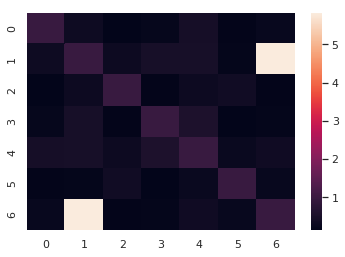

In [58]:
sns.heatmap(average_sim_matrix_5fold)

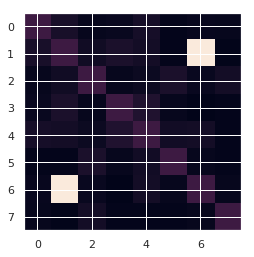

In [95]:
plt.imshow(overlapping[10])

In [61]:
kf10=KFold(n_splits=10,shuffle=True)

In [62]:
average_sim_matrix_10fold,overlapping_10=avg_similarity(pool_FS,num_fea,kf10)

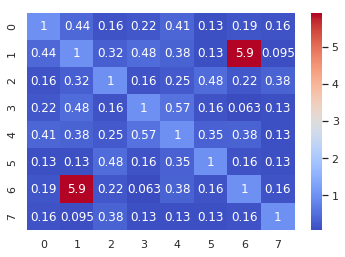

In [97]:
sns.heatmap(overlapping[10],annot=True,cmap="coolwarm")

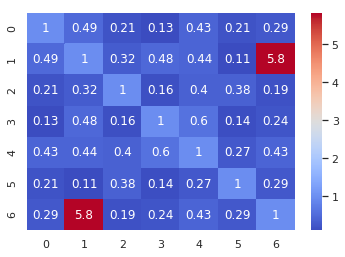

In [101]:
sns.heatmap(overlapping_10[100],annot=True,cmap="coolwarm")

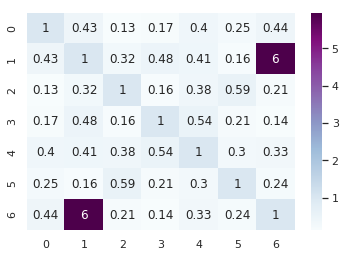

In [94]:
sns.heatmap(overlapping_10[20],annot=True,cmap="BuPu")

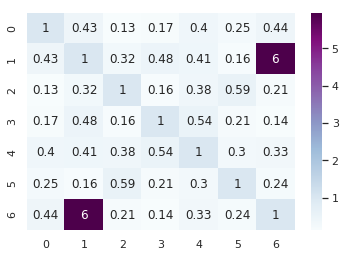

In [77]:

sns.heatmap(overlapping_10[20],annot=True,cmap="BuPu")

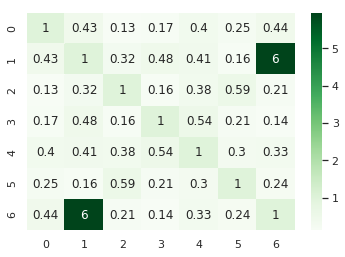

In [78]:
sns.heatmap(overlapping_10[20],annot=True,cmap="Greens")

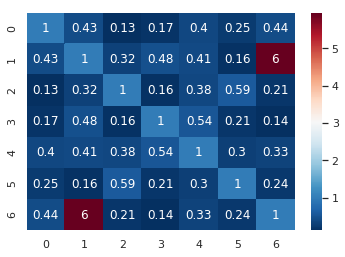

In [81]:

sns.heatmap(overlapping_10[20],annot=True,cmap="RdBu_r")

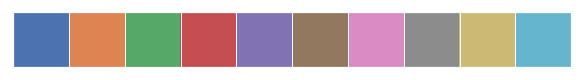

In [79]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

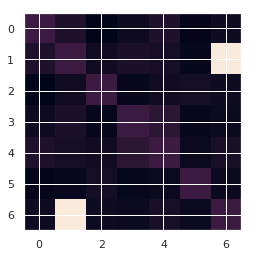

In [67]:
plt.imshow(overlapping_10[10])

In [83]:
average_sim_matrix_loo,overlapping_loo=avg_similarity(pool_FS,num_fea,loo)

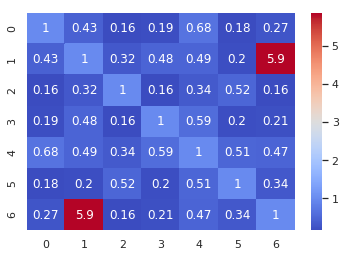

In [86]:
sns.heatmap(overlapping_loo[10],annot=True,cmap="coolwarm")

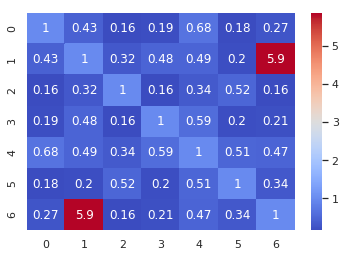

In [88]:
sns.heatmap(overlapping_loo[100],annot=True,cmap="coolwarm")

In [90]:
overlapping_loo[100]==overlapping_loo[20]

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

### 5-fold CV

In [34]:
# split data into 5 folds
kf5=KFold(n_splits=5,shuffle=True)

#ss = cross_validate(n_samples, n_folds=5, shuffle=True)

In [35]:
FS_performance_kf5=[]  
for FS in pool_FS:
    acc_k=[]
       
    for k in num_fea:
        _feature_ranking,_acc=training(kf5,k,FS)
        acc_k.append(_acc)
    FS_performance_kf5.append(acc_k)

Text(0, 0.5, 'Accuracy')

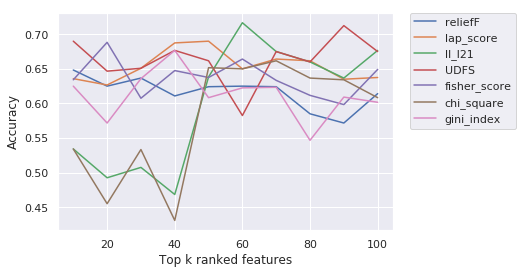

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
#def plot_performance(result,num_fea):
line1, = plt.plot(num_fea,FS_performance_kf5[0], label='reliefF')
line2, = plt.plot(num_fea,FS_performance_kf5[1], marker='', label='lap_score')
line3, = plt.plot(num_fea,FS_performance_kf5[2], marker='', label='ll_l21')
line4, = plt.plot(num_fea,FS_performance_kf5[3], marker='', label='UDFS')
line5, = plt.plot(num_fea,FS_performance_kf5[4], marker='', label='fisher_score')
line6, = plt.plot(num_fea,FS_performance_kf5[5], marker='', label='chi_square')
line7, = plt.plot(num_fea,FS_performance_kf5[6], marker='', label='gini_index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Top k ranked features')
plt.ylabel('Accuracy')

### 10-Fold CV

In [37]:
kf10=KFold(n_splits=10,shuffle=True)

In [38]:
FS_performance_kf10=[]  
for FS in pool_FS:
    acc_k=[]
       
    for k in num_fea:
        _feature_ranking,_acc=training(kf10,k,FS)
        acc_k.append(_acc)
    FS_performance_kf10.append(acc_k)

Text(0, 0.5, 'Accuracy')

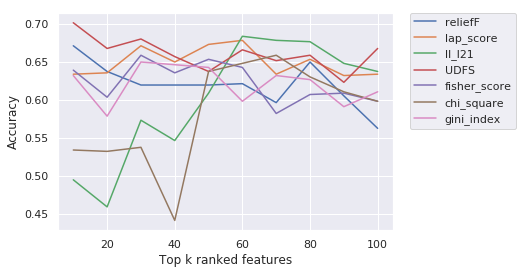

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
#def plot_performance(result,num_fea):
line1, = plt.plot(num_fea,FS_performance_kf10[0], label='reliefF')
line2, = plt.plot(num_fea,FS_performance_kf10[1], marker='', label='lap_score')
line3, = plt.plot(num_fea,FS_performance_kf10[2], marker='', label='ll_l21')
line4, = plt.plot(num_fea,FS_performance_kf10[3], marker='', label='UDFS')
line5, = plt.plot(num_fea,FS_performance_kf10[4], marker='', label='fisher_score')
line6, = plt.plot(num_fea,FS_performance_kf10[5], marker='', label='chi_square')
line7, = plt.plot(num_fea,FS_performance_kf10[6], marker='', label='gini_index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Top k ranked features')
plt.ylabel('Accuracy')

### LOO CV

In [82]:
from sklearn.model_selection import LeaveOneOut
loo=LeaveOneOut()

In [25]:
FS_performance_loo=[]  
fea_ranking_loo=[]
for FS in pool_FS:
    acc_k=[]
    fea_ranking_=[]
       
    for k in num_fea:
        _feature_ranking,_acc=training(loo,k,FS)
        acc_k.append(_acc)
        fea_ranking_.append(_feature_ranking)
    
    FS_performance_loo.append(acc_k)
    fea_ranking_loo.append(fea_ranking_)

Text(0, 0.5, 'Accuracy')

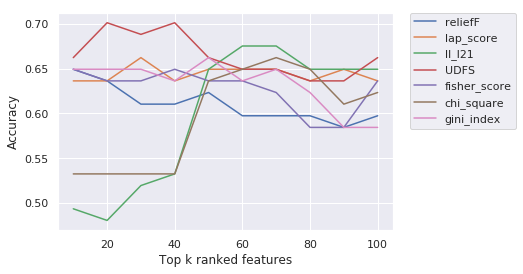

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
#def plot_performance(result,num_fea):
line1, = plt.plot(num_fea,FS_performance_loo[0], label='reliefF')
line2, = plt.plot(num_fea,FS_performance_loo[1], marker='', label='lap_score')
line3, = plt.plot(num_fea,FS_performance_loo[2], marker='', label='ll_l21')
line4, = plt.plot(num_fea,FS_performance_loo[3], marker='', label='UDFS')
line5, = plt.plot(num_fea,FS_performance_loo[4], marker='', label='fisher_score')
line6, = plt.plot(num_fea,FS_performance_loo[5], marker='', label='chi_square')
line7, = plt.plot(num_fea,FS_performance_loo[6], marker='', label='gini_index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Top k ranked features')
plt.ylabel('Accuracy')

In [28]:
#FS_performance_loo
labels_pool=['reliefF','lap_score','ll_l21','UDFS','fisher_score','chi_square','gini_index']
result_acc_loo=dict()
result_acc_loo['reliefF']=FS_performance_loo[0]
result_acc_loo['lap_score']=FS_performance_loo[1]
result_acc_loo['ll_l21']=FS_performance_loo[2]
result_acc_loo['UDFS']=FS_performance_loo[3]
result_acc_loo['fidher_score']=FS_performance_loo[4]
result_acc_loo['chi_square']=FS_performance_loo[5]
result_acc_loo['gini_index']=FS_performance_loo[6]

In [29]:
result_rank_loo=dict()
result_rank_loo['reliefF']=fea_ranking_loo[0]
result_rank_loo['lap_score']=fea_ranking_loo[1]
result_rank_loo['ll_l21']=fea_ranking_loo[2]
result_rank_loo['UDFS']=fea_ranking_loo[3]
result_rank_loo['fidher_score']=fea_ranking_loo[4]
result_rank_loo['chi_square']=fea_ranking_loo[5]
result_rank_loo['gini_index']=fea_ranking_loo[6]

In [ ]:
### Store loo ranking and accuracy

In [30]:
dst_fold = '/home/jupyter/project/Master_project/Results'

In [31]:
import os
f = os.path.join(dst_fold, 'accuracy_loo_LH' + '.mat' )
sio.savemat(f,result_acc_loo)

In [32]:
f1 = os.path.join(dst_fold, 'ranking_loo_LH' + '.mat' )
sio.savemat(f1,result_acc_loo)

In [36]:
ACC=accuracy_similarity_matrix(pool_FS,num_fea,kf5)

In [37]:
ACC


array([[1.        , 0.99731611, 0.99875494, 0.99807685, 0.99979585,
        0.9982141 , 0.99970004],
       [0.99731611, 1.        , 0.99607439, 0.99923779, 0.99751975,
        0.995535  , 0.99761535],
       [0.99875494, 0.99607439, 1.        , 0.99683419, 0.99855105,
        0.99945848, 0.99845536],
       [0.99807685, 0.99923779, 0.99683419, 1.        , 0.99828065,
        0.99629438, 0.99837632],
       [0.99979585, 0.99751975, 0.99855105, 0.99828065, 1.        ,
        0.99801032, 0.99990417],
       [0.9982141 , 0.995535  , 0.99945848, 0.99629438, 0.99801032,
        1.        , 0.99791468],
       [0.99970004, 0.99761535, 0.99845536, 0.99837632, 0.99990417,
        0.99791468, 1.        ]])

### FS-TO-FS Stability Matrix construction

In [27]:
result=avg_similarity(pool_FS,num_fea,kf5)

In [32]:
result_=[]
for k in num_fea:
    result_.append(result[k])


In [39]:
average_similarity=sum(result_)/len(num_fea)

In [38]:
len(result_)

10

In [40]:
average_similarity

array([[1.        , 0.00371429, 0.00149206, 0.00206349, 0.00396825,
        0.00142857, 0.00314286],
       [0.00371429, 1.        , 0.0031746 , 0.0047619 , 0.00419048,
        0.00203175, 0.05831746],
       [0.00149206, 0.0031746 , 1.        , 0.0015873 , 0.00298413,
        0.00412698, 0.00174603],
       [0.00206349, 0.0047619 , 0.0015873 , 1.        , 0.00539683,
        0.00133333, 0.00209524],
       [0.00396825, 0.00419048, 0.00298413, 0.00539683, 1.        ,
        0.00250794, 0.00406349],
       [0.00142857, 0.00203175, 0.00412698, 0.00133333, 0.00250794,
        1.        , 0.00196825],
       [0.00314286, 0.05831746, 0.00174603, 0.00209524, 0.00406349,
        0.00196825, 1.        ]])

In [49]:
similarities=[]
for k in num_fea:
    similarities.append(S_k[k])

In [56]:
S_k

{10: array([[1.00000000e+02, 4.76190476e-01, 1.58730159e-01, 2.85714286e-01,
         3.80952381e-01, 1.90476190e-01, 2.22222222e-01],
        [4.76190476e-01, 1.00000000e+02, 3.17460317e-01, 4.76190476e-01,
         3.80952381e-01, 3.17460317e-02, 5.74603175e+00],
        [1.58730159e-01, 3.17460317e-01, 1.00000000e+02, 1.58730159e-01,
         2.53968254e-01, 4.12698413e-01, 3.49206349e-01],
        [2.85714286e-01, 4.76190476e-01, 1.58730159e-01, 1.00000000e+02,
         7.30158730e-01, 2.22222222e-01, 1.90476190e-01],
        [3.80952381e-01, 3.80952381e-01, 2.53968254e-01, 7.30158730e-01,
         1.00000000e+02, 4.12698413e-01, 2.53968254e-01],
        [1.90476190e-01, 3.17460317e-02, 4.12698413e-01, 2.22222222e-01,
         4.12698413e-01, 1.00000000e+02, 4.44444444e-01],
        [2.22222222e-01, 5.74603175e+00, 3.49206349e-01, 1.90476190e-01,
         2.53968254e-01, 4.44444444e-01, 1.00000000e+02]]),
 20: array([[1.00000000e+02, 3.17460317e-01, 3.17460317e-01, 9.52380952e-02,


In [55]:
sum(similarities)/7

array([[142.85714286,   0.54875283,   0.24036281,   0.31746032,
          0.57596372,   0.17687075,   0.44897959],
       [  0.54875283, 142.85714286,   0.45351474,   0.68027211,
          0.6031746 ,   0.24036281,   8.33106576],
       [  0.24036281,   0.45351474, 142.85714286,   0.22675737,
          0.40816327,   0.62585034,   0.2675737 ],
       [  0.31746032,   0.68027211,   0.22675737, 142.85714286,
          0.78911565,   0.22675737,   0.28571429],
       [  0.57596372,   0.6031746 ,   0.40816327,   0.78911565,
        142.85714286,   0.33560091,   0.48072562],
       [  0.17687075,   0.24036281,   0.62585034,   0.22675737,
          0.33560091, 142.85714286,   0.3446712 ],
       [  0.44897959,   8.33106576,   0.2675737 ,   0.28571429,
          0.48072562,   0.3446712 , 142.85714286]])

In [43]:
SIMI=map(lambda x:Avg_Similarity_matrix(x),S_k)

In [45]:
for element in SIMI:
    print(element)
    

80.0
50.0
20.0
70.0
40.0
100.0
10.0
60.0
90.0
30.0


In [37]:
S10

array([[1.00000000e+02, 3.17460317e-01, 2.22222222e-01, 2.53968254e-01,
        3.49206349e-01, 9.52380952e-02, 2.53968254e-01],
       [3.17460317e-01, 1.00000000e+02, 3.17460317e-01, 4.76190476e-01,
        5.07936508e-01, 2.53968254e-01, 5.90476190e+00],
       [2.22222222e-01, 3.17460317e-01, 1.00000000e+02, 1.58730159e-01,
        3.17460317e-01, 3.49206349e-01, 1.58730159e-01],
       [2.53968254e-01, 4.76190476e-01, 1.58730159e-01, 1.00000000e+02,
        4.76190476e-01, 3.17460317e-01, 2.22222222e-01],
       [3.49206349e-01, 5.07936508e-01, 3.17460317e-01, 4.76190476e-01,
        1.00000000e+02, 1.26984127e-01, 3.80952381e-01],
       [9.52380952e-02, 2.53968254e-01, 3.49206349e-01, 3.17460317e-01,
        1.26984127e-01, 1.00000000e+02, 3.17460317e-01],
       [2.53968254e-01, 5.90476190e+00, 1.58730159e-01, 2.22222222e-01,
        3.80952381e-01, 3.17460317e-01, 1.00000000e+02]])

In [61]:
#FS_k_ranking=[]
FS_k=[]
#k=10
ranking_over_k={}
for k in num_fea:
    pool_FS=[reliefF,lap_score,ll_l21,UDFS,fisher_score,chi_square,gini_index]
    for FS in pool_FS:
        _feature_ranking=training(kf5,k,FS)
        #FS_k_ranking.append(_feature_ranking)
        FS_k.append(_feature_ranking)
    ranking_over_k[k]=FS_k
    

In [68]:
top_k_ranked_m={}
for k in num_fea:
    similarity=FS_to_FS_similarity(ranking_over_k[k])
    top_k_ranked_m[k]=similarity

In [76]:
top_k_ranked_m[20].shape

(70, 70)

In [ ]:
top_k_ranked_m=[]
for fs_k in ranking_over_k:
    similarity_m=FS_to_FS_similarity(fs_k)
    top_k_ranked_m.append(similarity_m)

In [119]:
ranking_over_k[0][0].shape

(5, 630)

In [ ]:
#Final similarity matrix
average_similarity=

In [103]:
sim=FS_to_FS_similarity(FS_k)

In [101]:
len(FS_k)

4

In [88]:
for i in range()

array([[1., 1., 1., 1.],
       [1., 1., 2., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [104]:
sim

array([[100.        ,   0.47619048,   0.15873016,   0.15873016],
       [  0.47619048, 100.        ,   0.31746032,   0.47619048],
       [  0.15873016,   0.31746032, 100.        ,   0.15873016],
       [  0.15873016,   0.47619048,   0.15873016, 100.        ]])

In [49]:
similarity=np.array(np.nan)

()

In [55]:
similarity_=dict()
columns=['reliefF','lap_score','ll_l21','UDFS']
rows=['reliefF','lap_score','ll_l21','UDFS']

In [ ]:
simila

## Sk or similarity matrix for k=10

In [58]:
def save_performance(file_name,dst_fold,performance):
    Pool_FS_names=['reliefF','lap_score','ll_l21','UDFS','CFS']
    d={}
    for name in Pool_FS_names:
        d[name]=performance[Pool_FS_names.index(name)]
    #dst_fold='/home/raoua/Desktop/BASIRA/working repo/intermediate/'
    f = os.path.join(dst_fold, file_name + '.mat' )
    sio.savemat(f,d)

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
def plot_performance(result,num_fea):
    line1, = plt.plot(num_fea,result['reliefF'][0], label='reliefF')
    line2, = plt.plot(num_fea,result['lap_score'][0], marker='', label='lap_score')
    line3, = plt.plot(num_fea,result['ll_l21'][0], marker='', label='ll_l21')
    line4, = plt.plot(num_fea,result['UDFS'][0], marker='', label='UDFS')
    line5, = plt.plot(num_fea,result['CFS'][0], marker='', label='CFS')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.xlabel('Top k ranked features')
    plt.ylabel('Accuracy')
    #plt.title('Feature selection methods performance using 5-fold CV')

### -------------- Main Program ------------------

In [60]:
## import cv method here
import os
## cv=instance()
##dst_fold='bla/bla/bla'
#performance_x=main_pipeline(cv)
## due to the fact that this pipeline is time consuming I chose to save the results of the pipeline so 
## I don't have to rerun the whole pipeline from zero
dst_fold='/home/raoua/Desktop/BASIRA/working repo/intermediate/'
save_performance('Pool_FS_Accuracy_10fold',dst_fold,performance10)
## Read the performance result for later processing
#result_file= sio.loadmat('blalalalal')


In [63]:
import scipy.io as sio
result=sio.loadmat('./intermediate/Pool_FS_Accuracy_10fold.mat')

Text(0.5, 1.0, 'Feature selection methods performance using 10-fold CV')

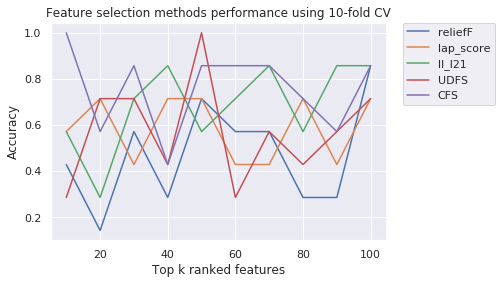

In [66]:
plot_performance(result,num_fea)
plt.title('Feature selection methods performance using 10-fold CV')

### Plot the results

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Text(0.5, 1.0, 'Feature selection methods performance using 5-fold CV')

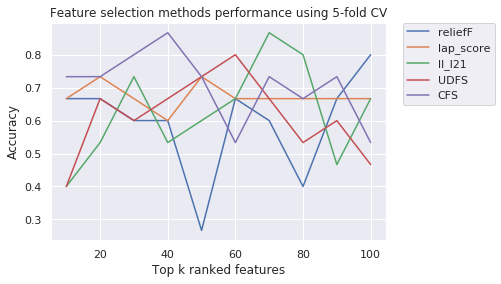

In [61]:
import matplotlib.pyplot as plt
#from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(num_fea,result['reliefF'][0], label='reliefF')
line2, = plt.plot(num_fea,result['lap_score'][0], marker='', label='lap_score')
line3, = plt.plot(num_fea,result['ll_l21'][0], marker='', label='ll_l21')
line4, = plt.plot(num_fea,result['UDFS'][0], marker='', label='UDFS')
line5, = plt.plot(num_fea,result['CFS'][0], marker='', label='CFS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Top k ranked features')
plt.ylabel('Accuracy')
plt.title('Feature selection methods performance using 5-fold CV')